<a href="https://colab.research.google.com/github/PaulinaPacyna/DL_speech_recognition/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/DL Project 3/')
if os.path.exists('X_train.npy') and os.path.exists('y_train.npy') and os.path.exists('class_names.npy'):
  X = np.load('X_train.npy', allow_pickle=True)
  y = np.load('y_train.npy', allow_pickle=True)
  classess = np.load('class_names.npy', allow_pickle=True)
else:
  X = convert_wav_to_image(paths)
  enc = OneHotEncoder() 
  y = enc.fit_transform(paths[['label']]).todense()
  classes = enc.get_feature_names()
  np.save('X_train.npy', X)
  np.save('y_train.npy', y)
  np.save('class_names.npy', classes)

In [4]:
classes = [classess[i].split("_")[1] for i in range(len(classess))]

In [5]:
X = (X - np.mean(X))/np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape

In [6]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import argmax

# drop-based learning scheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 1e-5):
        lrate = 1e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [7]:
import librosa
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig('picConfMatrix.png', dpi=400)
    plt.tight_layout()


# CNN + LSTM + Attention

In [ ]:
# CNN part
input = L.Input(X_train.shape[1:], name='input')
x = L.Reshape((1, -1))(input)

m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, None),
                   padding='same', sr=16000, n_mels=80,
                   fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                   return_decibel_melgram=True, trainable_fb=False,
                   trainable_kernel=False,
                   name='mel_stft')
m.trainable = False
x = m(x)

x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

x = L.Permute((2, 1, 3))(x)

x = L.Conv2D(20, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D((2, 1))(x)
x = L.Dropout(0.1)(x)

x = L.Conv2D(40, (3, 3), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)
x = L.MaxPooling2D((2, 2))(x)
x = L.Dropout(0.1)(x)

x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)


# LSTM part
x = L.Lambda(lambda x: K.squeeze(x, -1), name='sqeeze_last_dim')(x)
x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)  # it returns [b_s, seq_len, vec_dim]

xFirst = L.Lambda(lambda q: q[:, -1])(x)  # to [b_s, vec_dim]
query = L.Dense(128)(xFirst)

# Attention Part
attScores = L.Dot(axes=[1, 2])([query, x])
attScores = L.Softmax(name='attSoftmax')(attScores)

# Rescaling
attVector = L.Dot(axes=[1, 1])([attScores, x])

x = L.Dense(64, activation='relu')(attVector)
x = L.Dense(32)(x)

output = L.Dense(31, activation='softmax', name='output')(x)

model = Model(inputs=[input], outputs=[output])

In [ ]:
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', 'sparse_categorical_accuracy'])
model.summary()

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN2.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(X_train, argmax(y_train, axis=1), epochs=50, batch_size=128, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate], validation_split=0.3)

model.save('/content/drive/MyDrive/saved_models/model-attRNN2.h5')

Epoch 1/50
Changing learning rate to 0.001
284/284 - 50s - loss: 2.5412 - accuracy: 0.2668 - sparse_categorical_accuracy: 0.2668 - val_loss: 3.4197 - val_accuracy: 0.0380 - val_sparse_categorical_accuracy: 0.0380

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.03798, saving model to model-attRNN.h5
Epoch 2/50
Changing learning rate to 0.001
284/284 - 11s - loss: 1.2557 - accuracy: 0.6170 - sparse_categorical_accuracy: 0.6170 - val_loss: 1.3692 - val_accuracy: 0.6215 - val_sparse_categorical_accuracy: 0.6215

Epoch 00002: val_sparse_categorical_accuracy improved from 0.03798 to 0.62150, saving model to model-attRNN.h5
Epoch 3/50
Changing learning rate to 0.001
284/284 - 11s - loss: 0.8969 - accuracy: 0.7302 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.7953 - val_accuracy: 0.7666 - val_sparse_categorical_accuracy: 0.7666

Epoch 00003: val_sparse_categorical_accuracy improved from 0.62150 to 0.76659, saving model to model-attRNN.h5
Epoch 4/50
Changing learning

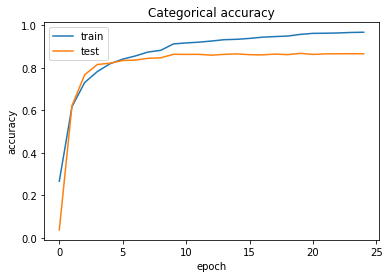

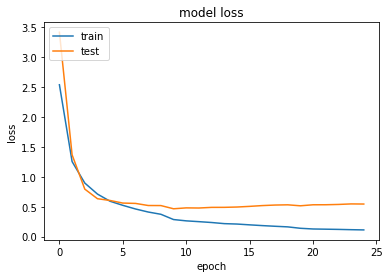

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
trainEval = model.evaluate(X_train, argmax(y_train, axis=1), use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(X_test, argmax(y_test, axis=1), verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nTest: {}'.format(model.metrics_names, trainEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'accuracy', 'sparse_categorical_accuracy'] 
Train: [0.21258951723575592, 0.9461385607719421, 0.9461385607719421] 
Test: [0.4786294102668762, 0.8710798621177673, 0.8710798621177673]


In [ ]:
# Attention Plots
attSpeechModel = Model(inputs=model.input,
                       outputs=[model.get_layer('output').output, 
                                model.get_layer('attSoftmax').output,
                                model.get_layer('mel_stft').output])

In [ ]:
outputs, attention, specs = attSpeechModel.predict(X_test)

In [ ]:
argmax(outputs, axis=1)

<tf.Tensor: shape=(12946,), dtype=int64, numpy=array([30, 20, 17, ...,  7, 12, 13])>

In [ ]:
id = 10

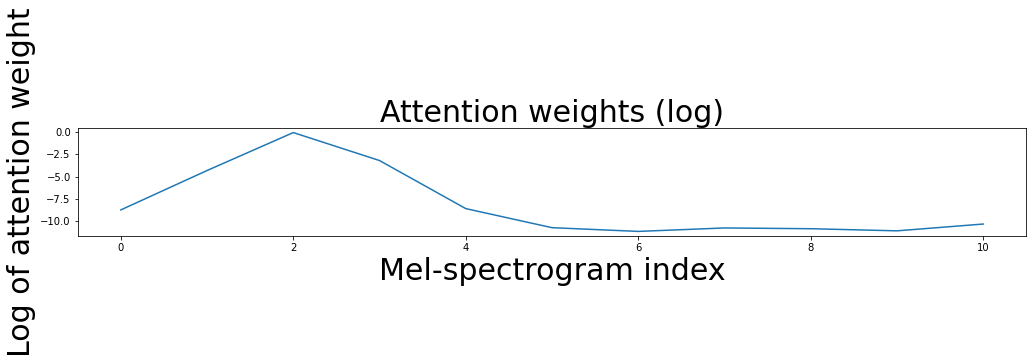

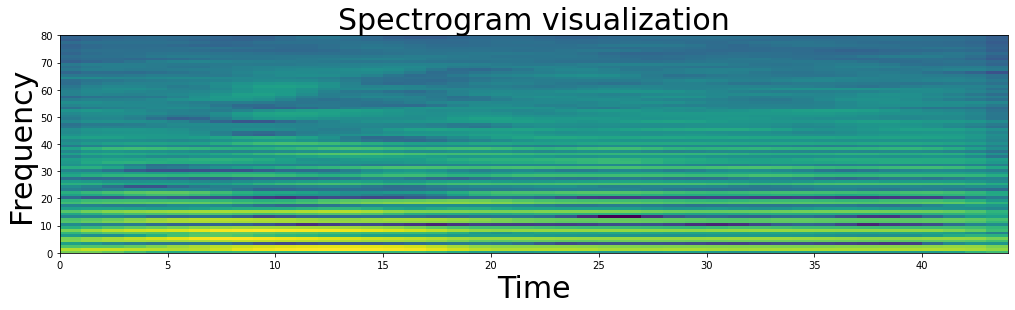

In [ ]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attention[id]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[id,:,:,0])

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/saved_models/model-attRNN.h5', custom_objects={'Melspectrogram':Melspectrogram, 'Normalization2D':Normalization2D})

In [ ]:
y_pred = model.predict(X_test, verbose=1)

405/405 [==============================] - 36s 6ms/step


In [ ]:
cm = confusion_matrix(argmax(y_test, axis=1), argmax(y_pred,1))

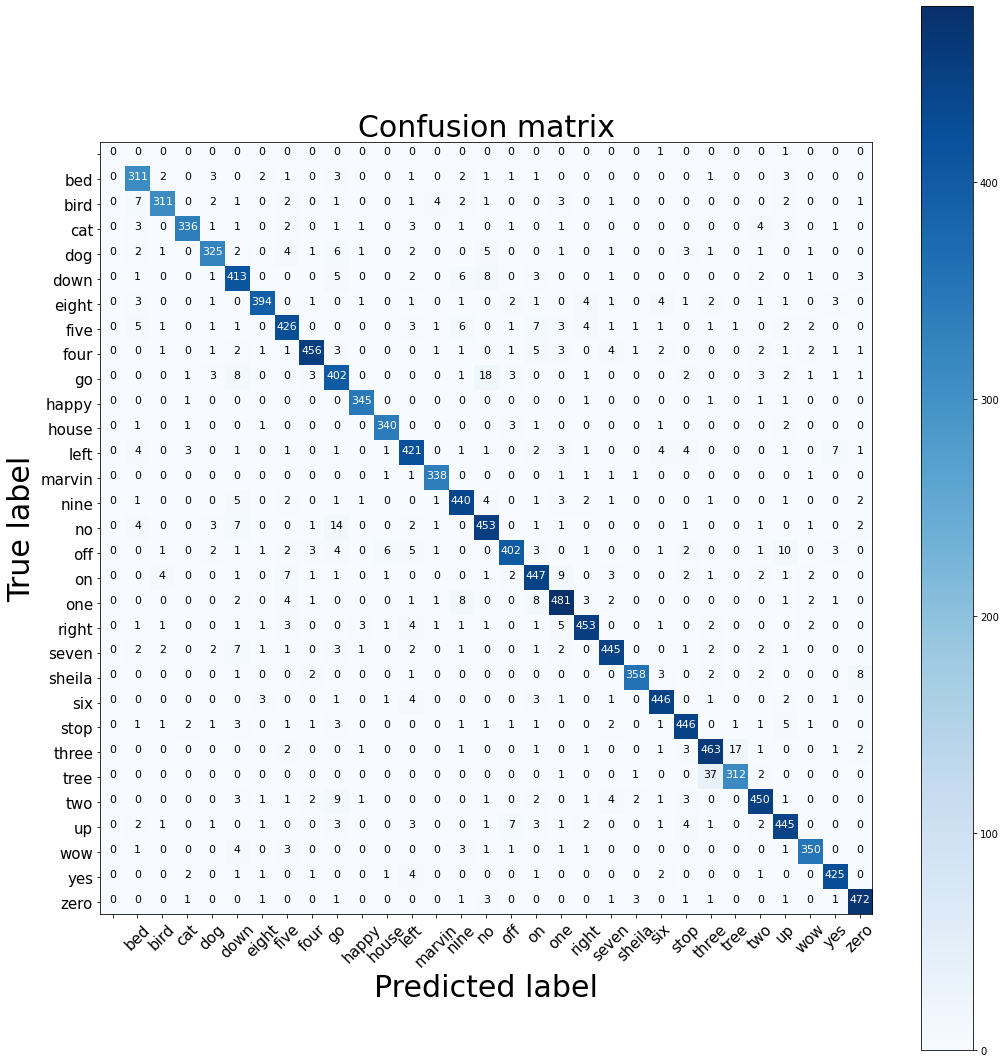

In [ ]:
plot_confusion_matrix(cm, classes)

# CNN + LSTM (imp) attention

In [ ]:
# CNN part
def cnn_LSTM_model():
    input = L.Input(X_train.shape[1:], name='input')
    x = L.Reshape((1, -1))(input)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, None),
                      padding='same', sr=16000, n_mels=80,
                      fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                      return_decibel_melgram=True, trainable_fb=False,
                      trainable_kernel=False,
                      name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)


    # LSTM part
    x = L.Lambda(lambda x: K.squeeze(x, -1), name='sqeeze_last_dim')(x)
    x = L.Bidirectional(L.LSTM(128, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(128, return_sequences=True))(x)  # it returns [b_s, seq_len, vec_dim]

    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # to [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # Attention Part
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)

    # Rescaling
    attVector = L.Dot(axes=[1, 1])([attScores, x])

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(31, activation='softmax', name='output')(x)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
model2 = cnn_LSTM_model()
model2.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', 'sparse_categorical_accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 44, 128)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 5632)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 44, 1)    1091664     reshape[0][0]                    
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, 44, 1)    0           mel_stft[0][0]                   
______________________________________________________________________________________________

In [ ]:
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-att-cnn-LSTM.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results2 = model2.fit(X_train, argmax(y_train, axis=1), epochs=50, batch_size=128, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate], validation_split=0.3)

model2.save('/content/drive/MyDrive/saved_models/model-att-cnn-LSTM.h5')

Epoch 1/50
Changing learning rate to 0.001
284/284 - 58s - loss: 2.1494 - accuracy: 0.3699 - sparse_categorical_accuracy: 0.3699 - val_loss: 3.3629 - val_accuracy: 0.0541 - val_sparse_categorical_accuracy: 0.0541

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.05407, saving model to model-att-cnn-LSTM.h5
Epoch 2/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.7898 - accuracy: 0.7695 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.6901 - val_accuracy: 0.7985 - val_sparse_categorical_accuracy: 0.7985

Epoch 00002: val_sparse_categorical_accuracy improved from 0.05407 to 0.79852, saving model to model-att-cnn-LSTM.h5
Epoch 3/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.4466 - accuracy: 0.8684 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.4687 - val_accuracy: 0.8650 - val_sparse_categorical_accuracy: 0.8650

Epoch 00003: val_sparse_categorical_accuracy improved from 0.79852 to 0.86501, saving model to model-att-cnn-LSTM.h5
Epoch 4/50

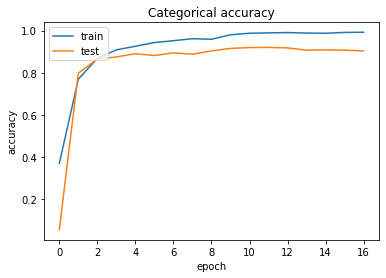

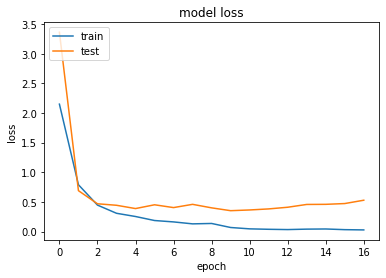

In [ ]:
# summarize history for categorical accuracy
plt.plot(results2.history['sparse_categorical_accuracy'])
plt.plot(results2.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results2.history['loss'])
plt.plot(results2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow import keras
model2 = keras.models.load_model('/content/drive/MyDrive/saved_models/model-att-cnn-LSTM.h5', custom_objects={'Melspectrogram':Melspectrogram, 'Normalization2D':Normalization2D})

In [ ]:
trainEval = model2.evaluate(X_train, argmax(y_train, axis=1), use_multiprocessing=False, workers=4,verbose=0)
testEval = model2.evaluate(X_test, argmax(y_test, axis=1), verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nTest: {}'.format(model2.metrics_names, trainEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'accuracy', 'sparse_categorical_accuracy'] 
Train: [0.17994889616966248, 0.9605260491371155, 0.9605260491371155] 
Test: [0.1914582997560501, 0.9573613405227661, 0.9573613405227661]


In [ ]:
y_pred2 = model2.predict(X_test, verbose=1)

405/405 [==============================] - 8s 13ms/step


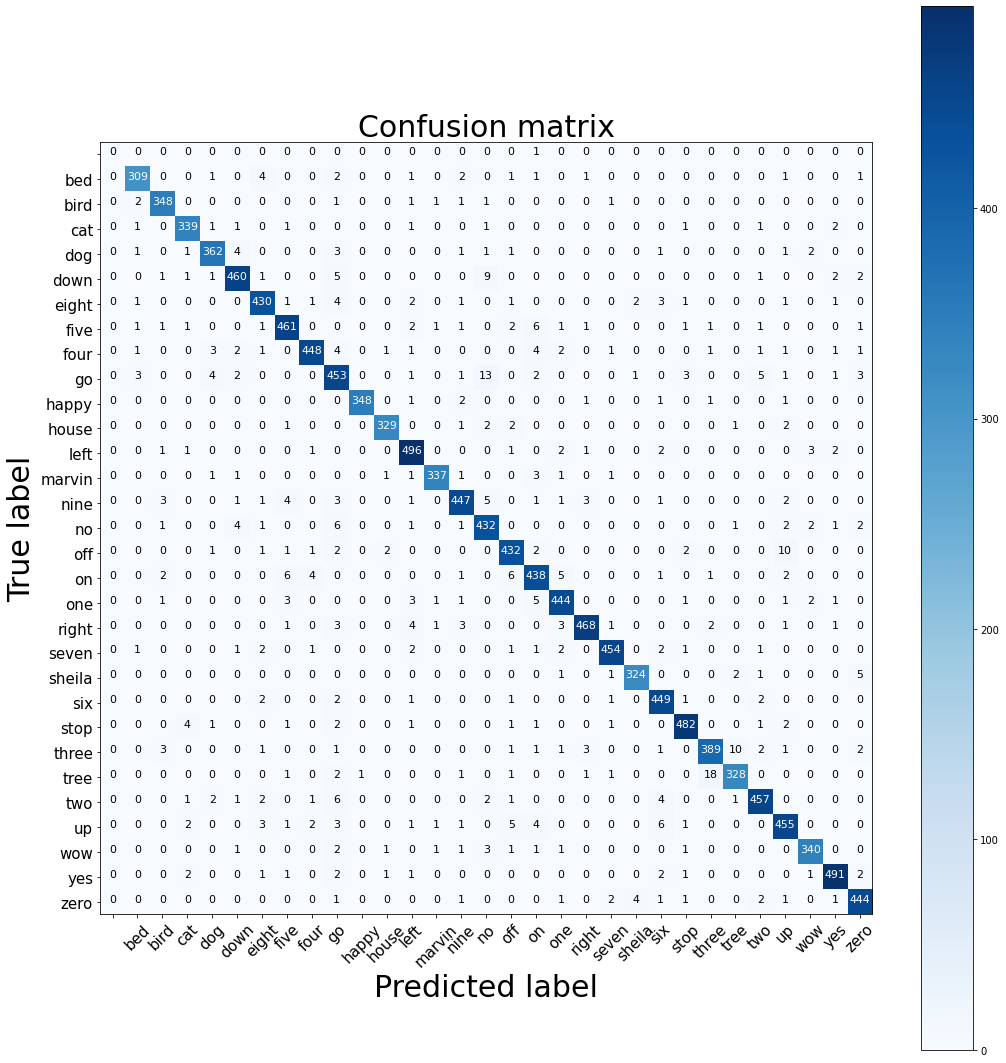

In [ ]:
cm2 = confusion_matrix(argmax(y_test, axis=1), argmax(y_pred2,1))
plot_confusion_matrix(cm2, classes)

# cnn + LSTM without attention

In [ ]:
# CNN part
def cnn_LSTM_model_noatt():
    input = L.Input(X_train.shape[1:], name='input')
    x = L.Reshape((1, -1))(input)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, None),
                      padding='same', sr=16000, n_mels=80,
                      fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                      return_decibel_melgram=True, trainable_fb=False,
                      trainable_kernel=False,
                      name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)


    # LSTM part
    x = L.Lambda(lambda x: K.squeeze(x, -1), name='sqeeze_last_dim')(x)
    x = L.Bidirectional(L.LSTM(128, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(128, return_sequences=True))(x)  # it returns [b_s, seq_len, vec_dim]

    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(64, return_sequences=True))(x)
    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # to [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    x = L.Dense(64, activation='relu')(query)
    x = L.Dense(32)(x)

    output = L.Dense(31, activation='softmax', name='output')(x)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
model3 = cnn_LSTM_model_noatt()
model3.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', 'sparse_categorical_accuracy'])
model3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 44, 128)]         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 5632)           0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 44, 1)         1091664   
_________________________________________________________________
mel_stft_norm (Normalization (None, 80, 44, 1)         0         
_________________________________________________________________
permute_1 (Permute)          (None, 44, 80, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 80, 10)        60        
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 80, 10)        40  

In [ ]:
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-cnn-LSTM.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results3 = model3.fit(X_train, argmax(y_train, axis=1), epochs=50, batch_size=128, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate], validation_split=0.3)

model3.save('/content/drive/MyDrive/saved_models/model-cnn-LSTM.h5')

Epoch 1/50
Changing learning rate to 0.001
284/284 - 27s - loss: 2.8175 - accuracy: 0.1780 - sparse_categorical_accuracy: 0.1780 - val_loss: 3.3565 - val_accuracy: 0.0492 - val_sparse_categorical_accuracy: 0.0492

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.04924, saving model to model-cnn-LSTM.h5
Epoch 2/50
Changing learning rate to 0.001
284/284 - 14s - loss: 1.4422 - accuracy: 0.5617 - sparse_categorical_accuracy: 0.5617 - val_loss: 1.6961 - val_accuracy: 0.4945 - val_sparse_categorical_accuracy: 0.4945

Epoch 00002: val_sparse_categorical_accuracy improved from 0.04924 to 0.49450, saving model to model-cnn-LSTM.h5
Epoch 3/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.8763 - accuracy: 0.7402 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.7423 - val_accuracy: 0.7811 - val_sparse_categorical_accuracy: 0.7811

Epoch 00003: val_sparse_categorical_accuracy improved from 0.49450 to 0.78114, saving model to model-cnn-LSTM.h5
Epoch 4/50
Changing le

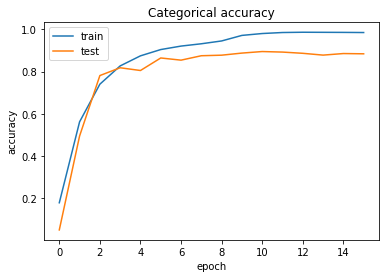

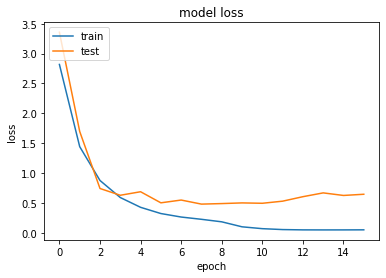

In [ ]:
# summarize history for categorical accuracy
plt.plot(results3.history['sparse_categorical_accuracy'])
plt.plot(results3.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results3.history['loss'])
plt.plot(results3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
trainEval = model3.evaluate(X_train, argmax(y_train, axis=1), use_multiprocessing=False, workers=4,verbose=0)
testEval = model3.evaluate(X_test, argmax(y_test, axis=1), verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nTest: {}'.format(model3.metrics_names, trainEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'accuracy', 'sparse_categorical_accuracy'] 
Train: [0.18667247891426086, 0.9585369229316711, 0.9585369229316711] 
Test: [0.5275520086288452, 0.8910860419273376, 0.8910860419273376]


In [ ]:
from tensorflow import keras
model3 = keras.models.load_model('/content/drive/MyDrive/saved_models/model-cnn-LSTM.h5', custom_objects={'Melspectrogram':Melspectrogram, 'Normalization2D':Normalization2D})

In [ ]:
y_pred3 = model3.predict(X_test, verbose=1)

405/405 [==============================] - 40s 14ms/step


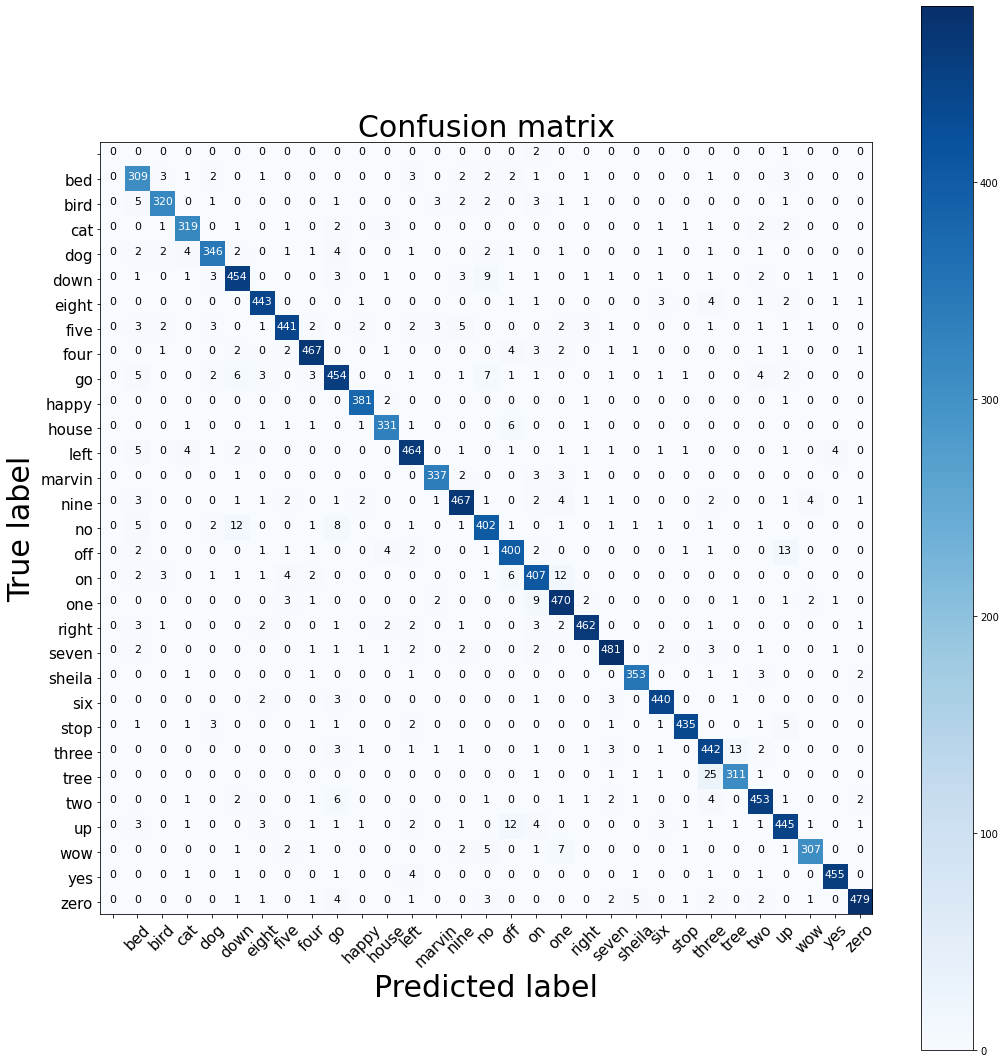

In [ ]:
cm3 = confusion_matrix(argmax(y_test, axis=1), argmax(y_pred3,1))
plot_confusion_matrix(cm3, classes)

# CNN + GRU (without attention)

In [ ]:
# CNN part
def cnn_GRU_model_noatt():
    input = L.Input(X_train.shape[1:], name='input')
    x = L.Reshape((1, -1))(input)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, None),
                      padding='same', sr=16000, n_mels=80,
                      fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                      return_decibel_melgram=True, trainable_fb=False,
                      trainable_kernel=False,
                      name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)


    # LSTM part
    x = L.Lambda(lambda x: K.squeeze(x, -1), name='sqeeze_last_dim')(x)
    x = L.Bidirectional(L.GRU(128, return_sequences=True))(x)
    x = L.Bidirectional(L.GRU(128, return_sequences=True))(x)  # it returns [b_s, seq_len, vec_dim]

    x = L.Bidirectional(L.GRU(64, return_sequences=True))(x)
    x = L.Bidirectional(L.GRU(64, return_sequences=True))(x)
    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # to [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    x = L.Dense(64, activation='relu')(query)
    x = L.Dense(32)(x)

    output = L.Dense(31, activation='softmax', name='output')(x)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
model4 = cnn_GRU_model_noatt()
model4.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', 'sparse_categorical_accuracy'])
model4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 44, 128)]         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 5632)           0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 44, 1)         1091664   
_________________________________________________________________
mel_stft_norm (Normalization (None, 80, 44, 1)         0         
_________________________________________________________________
permute_1 (Permute)          (None, 44, 80, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 80, 10)        60        
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 80, 10)        40  

In [ ]:
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-cnn-GRU.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results4 = model4.fit(X_train, argmax(y_train, axis=1), epochs=50, batch_size=128, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate], validation_split=0.3)

model4.save('/content/drive/MyDrive/saved_models/model-cnn-GRU.h5')

Epoch 1/50
Changing learning rate to 0.001
284/284 - 26s - loss: 2.7163 - accuracy: 0.1981 - sparse_categorical_accuracy: 0.1981 - val_loss: 3.4028 - val_accuracy: 0.1679 - val_sparse_categorical_accuracy: 0.1679

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.16794, saving model to model-cnn-GRU.h5
Epoch 2/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.8633 - accuracy: 0.7406 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.8817 - val_accuracy: 0.7440 - val_sparse_categorical_accuracy: 0.7440

Epoch 00002: val_sparse_categorical_accuracy improved from 0.16794 to 0.74400, saving model to model-cnn-GRU.h5
Epoch 3/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.4312 - accuracy: 0.8715 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.5176 - val_accuracy: 0.8506 - val_sparse_categorical_accuracy: 0.8506

Epoch 00003: val_sparse_categorical_accuracy improved from 0.74400 to 0.85060, saving model to model-cnn-GRU.h5
Epoch 4/50
Changing learn

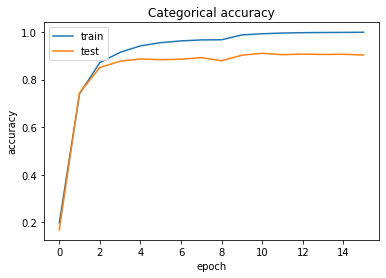

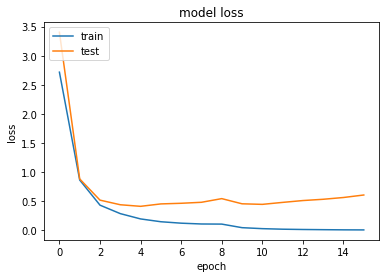

In [ ]:
# summarize history for categorical accuracy
plt.plot(results4.history['sparse_categorical_accuracy'])
plt.plot(results4.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results4.history['loss'])
plt.plot(results4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow import keras
model4 = keras.models.load_model('/content/drive/MyDrive/saved_models/model-cnn-GRU.h5', custom_objects={'Melspectrogram':Melspectrogram, 'Normalization2D':Normalization2D})

In [ ]:
trainEval = model4.evaluate(X_train, argmax(y_train, axis=1), use_multiprocessing=False, workers=4,verbose=0)
testEval = model4.evaluate(X_test, argmax(y_test, axis=1), verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nTest: {}'.format(model4.metrics_names, trainEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'accuracy', 'sparse_categorical_accuracy'] 
Train: [0.2069677710533142, 0.9579575657844543, 0.9579575657844543] 
Test: [0.19773302972316742, 0.9601421356201172, 0.9601421356201172]


In [ ]:
y_pred4 = model4.predict(X_test, verbose=1)

405/405 [==============================] - 7s 12ms/step


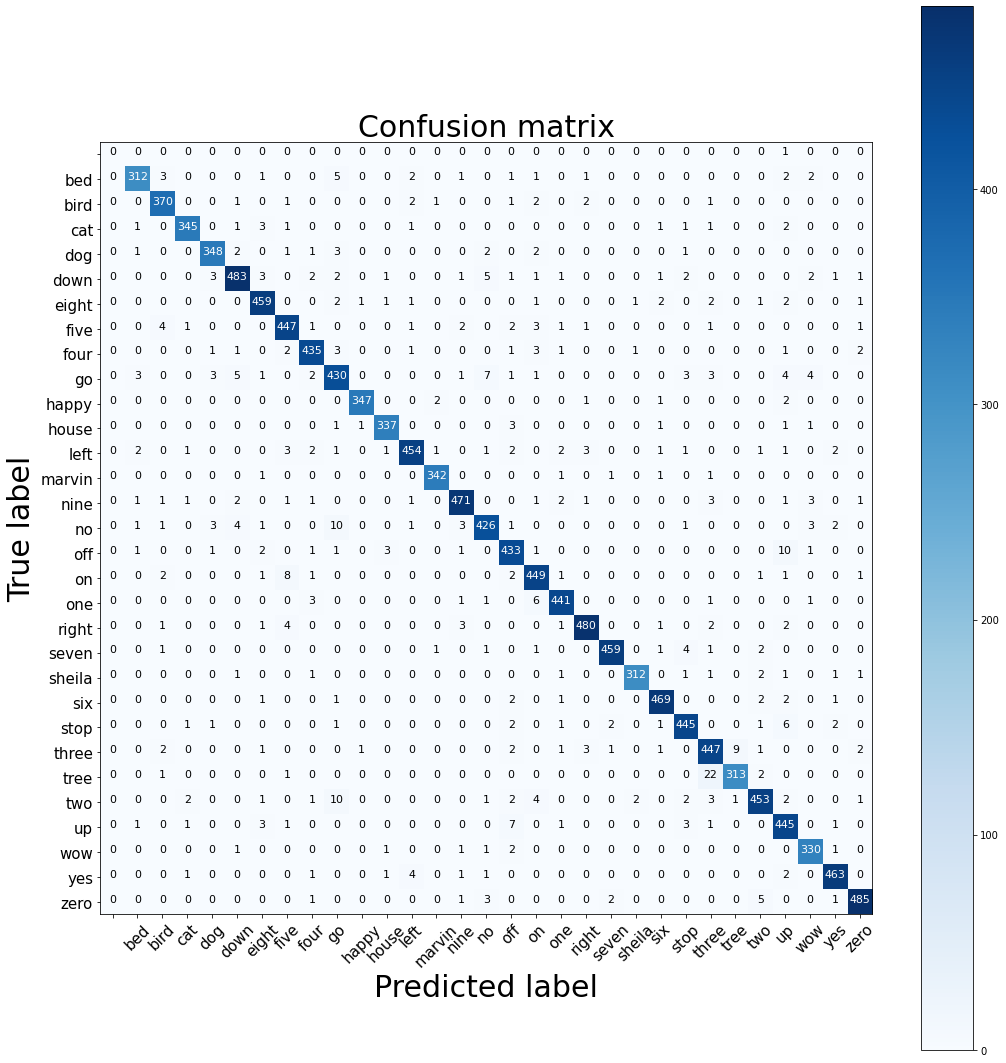

In [ ]:
cm4 = confusion_matrix(argmax(y_test, axis=1), argmax(y_pred4,1))
plot_confusion_matrix(cm4, classes)

# CNN + GRU + att

In [ ]:
# CNN part
def cnn_GRU_model_att():
    input = L.Input(X_train.shape[1:], name='input')
    x = L.Reshape((1, -1))(input)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, None),
                      padding='same', sr=16000, n_mels=80,
                      fmin=40.0, fmax=16000 / 2, power_melgram=1.0,
                      return_decibel_melgram=True, trainable_fb=False,
                      trainable_kernel=False,
                      name='mel_stft')
    m.trainable = False
    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)


    # LSTM part
    x = L.Lambda(lambda x: K.squeeze(x, -1), name='sqeeze_last_dim')(x)
    x = L.Bidirectional(L.GRU(128, return_sequences=True))(x)
    x = L.Bidirectional(L.GRU(128, return_sequences=True))(x)  # it returns [b_s, seq_len, vec_dim]

    x = L.Bidirectional(L.GRU(64, return_sequences=True))(x)
    x = L.Bidirectional(L.GRU(64, return_sequences=True))(x)
    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # to [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # Attention Part
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)

    # Rescaling
    attVector = L.Dot(axes=[1, 1])([attScores, x])

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(31, activation='softmax', name='output')(x)

    model = Model(inputs=[input], outputs=[output])
    return model

In [ ]:
model5 = cnn_GRU_model_att()
model5.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy', 'sparse_categorical_accuracy'])
model5.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 44, 128)]    0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 5632)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 44, 1)    1091664     reshape_2[0][0]                  
__________________________________________________________________________________________________
mel_stft_norm (Normalization2D) (None, 80, 44, 1)    0           mel_stft[0][0]                   
____________________________________________________________________________________________

In [ ]:
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-att-cnn-GRU.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results5 = model5.fit(X_train, argmax(y_train, axis=1), epochs=50, batch_size=128, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate], validation_split=0.3)

model5.save('/content/drive/MyDrive/saved_models/model-att-cnn-GRU.h5')

Epoch 1/50
Changing learning rate to 0.001
284/284 - 27s - loss: 2.0413 - accuracy: 0.4076 - sparse_categorical_accuracy: 0.4076 - val_loss: 2.9248 - val_accuracy: 0.2278 - val_sparse_categorical_accuracy: 0.2278

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.22781, saving model to model-att-cnn-GRU.h5
Epoch 2/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.6198 - accuracy: 0.8158 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.6227 - val_accuracy: 0.8161 - val_sparse_categorical_accuracy: 0.8161

Epoch 00002: val_sparse_categorical_accuracy improved from 0.22781 to 0.81609, saving model to model-att-cnn-GRU.h5
Epoch 3/50
Changing learning rate to 0.001
284/284 - 14s - loss: 0.3865 - accuracy: 0.8869 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.4270 - val_accuracy: 0.8764 - val_sparse_categorical_accuracy: 0.8764

Epoch 00003: val_sparse_categorical_accuracy improved from 0.81609 to 0.87641, saving model to model-att-cnn-GRU.h5
Epoch 4/50
Ch

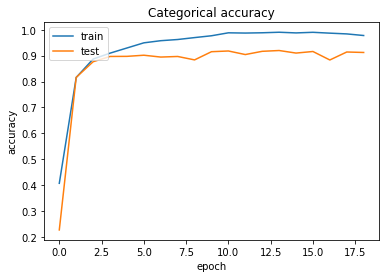

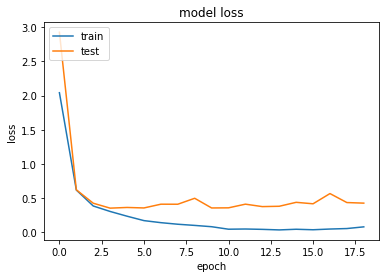

In [ ]:
# summarize history for categorical accuracy
plt.plot(results5.history['sparse_categorical_accuracy'])
plt.plot(results5.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results5.history['loss'])
plt.plot(results5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow import keras
model5 = keras.models.load_model('/content/drive/MyDrive/saved_models/model-att-cnn-GRU.h5', custom_objects={'Melspectrogram':Melspectrogram, 'Normalization2D':Normalization2D})

In [ ]:
trainEval = model5.evaluate(X_train, argmax(y_train, axis=1), use_multiprocessing=False, workers=4,verbose=0)
testEval = model5.evaluate(X_test, argmax(y_test, axis=1), verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nTest: {}'.format(model5.metrics_names, trainEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'accuracy', 'sparse_categorical_accuracy'] 
Train: [0.1373545080423355, 0.969989001750946, 0.969989001750946] 
Test: [0.39759090542793274, 0.9175034761428833, 0.9175034761428833]


In [ ]:
y_pred5 = model5.predict(X_test, verbose=1)

405/405 [==============================] - 7s 11ms/step


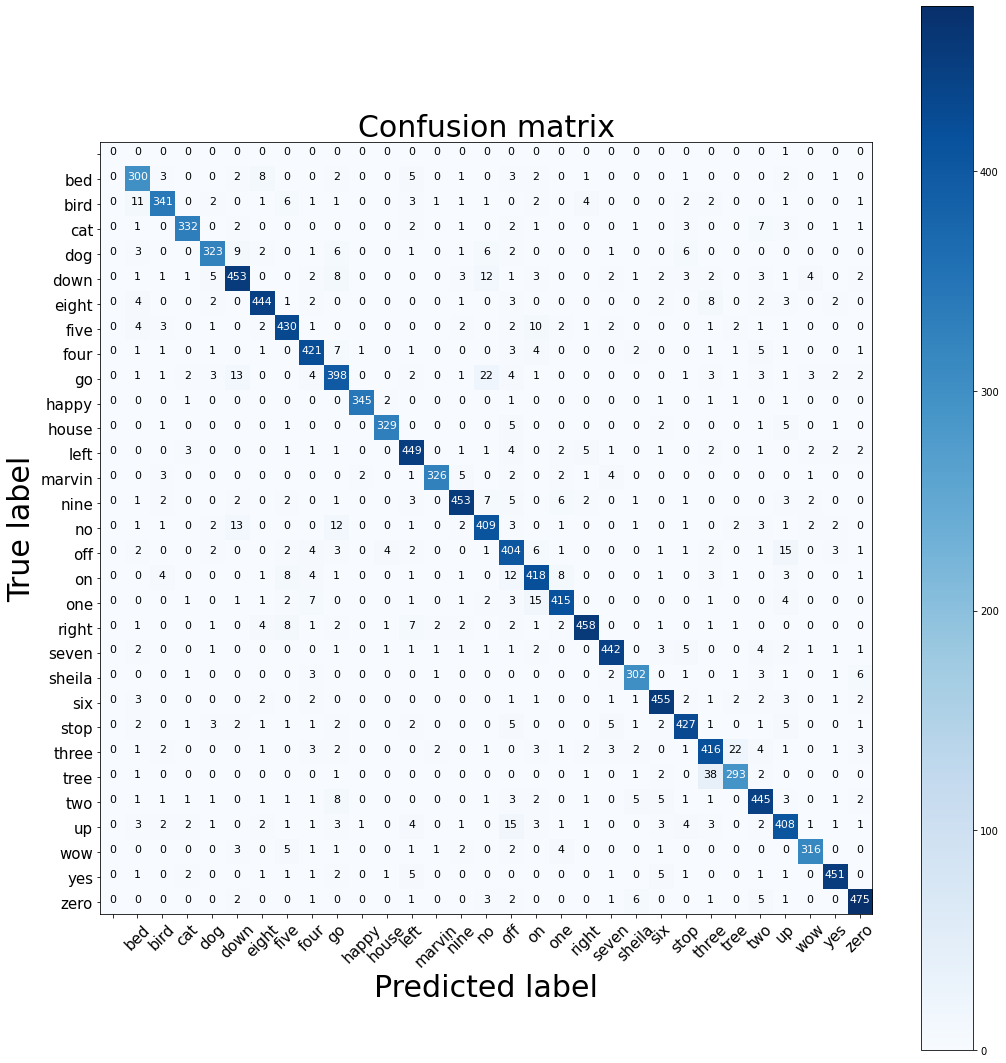

In [ ]:
cm5 = confusion_matrix(argmax(y_test, axis=1), argmax(y_pred5,1))
plot_confusion_matrix(cm5, classes)

# Kaggle

In [ ]:
import json
import os 
import py7zr

In [ ]:
if not os.path.isdir('train'):
  !pip install kaggle
  !pip install py7zr
  import py7zr
  !mkdir /root/.kaggle
  !touch /root/.kaggle/kaggle.json

  api_token = {"username":"paulinapacyna","key":"31e4c572f1ddefc96883c2195f33726b"} 

  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle config path -p /root
  !kaggle competitions download -c tensorflow-speech-recognition-challenge
  

In [ ]:
with py7zr.SevenZipFile('test.7z', mode='r') as z:
      z.extractall()

In [ ]:
def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float) 

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows(), total = df.shape[0]):
        x = audio2mel(row['path'])
        X.append(x.transpose())
    X = np.array(X) 
    return X


In [ ]:
if os.path.exists('X_test.npy'):
  X_kaggle = np.load('X_test.npy', allow_pickle=True)  
else:
  paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('test/audio') for f in fn if f[-4:]=='.wav']
  paths = pd.DataFrame(paths, columns=['path'])
  X_kaggle = convert_wav_to_image(paths) 
  np.save('X_test.npy', X_kaggle) 

In [8]:
X_kaggle = np.load('kaggle.npy', allow_pickle=True)  

In [13]:
X_kaggle.shape

(158538,)

In [14]:
np.max(X_kaggle)

30

In [ ]:
X_kaggle = (X_kaggle - np.mean(X_kaggle)) / np.std(X_kaggle)
import keras